In [1]:
import os
import scanpy
import anndata
import scanpy as sc
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import re
import sklearn
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from collections import Counter
import random
import seaborn
import sys
import shutil
import scvelo as scv
import bbknn
import tqdm
#Load my pipeline functions
import importlib
import importlib.util
spec = importlib.util.spec_from_file_location("ScanpyUtilsMT", os.path.expanduser("../../utils/ScanpyUtilsMT.py"))
sc_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sc_utils)
sc.settings.figdir='/wynton/group/ye/mtschmitz/figures/macWbSupervise/'
scv.settings.figdir='/wynton/group/ye/mtschmitz/figures/macWbSupervise/'
sc.settings.file_format_figs='pdf'
sc.settings.autosave=False
sc.settings.autoshow=True

In [8]:
files=[]

for f in os.listdir('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT_fixed_kallisto'):
    if re.search('E80.*otor.*',f):
        files.append(f)

for f in os.listdir('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT_fixed_kallisto'):
    if re.search('E80.*PFC.*',f):
        files.append(f)

for f in os.listdir('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT_fixed_kallisto'):
    if re.search('E90.*otor.*',f):
        files.append(f)

for f in os.listdir('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT_fixed_kallisto'):
    if re.search('E90.*PFC.*',f):
        files.append(f)


In [12]:
adatas=[]
filepath='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT_fixed_kallisto'
filename='aem_cellbended_150_750_175e_V0.2'
min_genes=800
for f in files:
    print(f,flush=True)
    try:
        if os.path.exists(os.path.join(filepath,f,filename,'aem_cellbended_filtered.h5')):
            sadata = sc_utils.readCellbenderH5(os.path.join(filepath,f,filename,'aem_cellbended_filtered.h5'))
            sadata =sadata[sadata.obs['latent_cell_probability']>.99,:]
            sc.pp.filter_cells(sadata,min_genes=min_genes)
        else:
            #continue
            sadata=sc_utils.loadPlainKallisto(os.path.join(filepath,f,'all_em'),min_genes=min_genes)

        sadata.obs.index=[re.sub("-1","",x) for x in sadata.obs.index]
        sadata.uns['name']=f
        sadata.obs['file_name']=f
        sadata.uns['name']=sc_utils.macaque_process_irregular_names(sadata.uns['name'])
        sadata.obs['batch_name']=str(sadata.uns['name'])
        sadata.obs['timepoint']=sc_utils.tp_format_macaque(sadata.uns['name'])
        regionstring=sc_utils.region_format_macaque(sadata.uns['name'])
        regionstring=regionstring.lower()
        sadata.obs['region']=regionstring
        if not os.path.exists(os.path.join(filepath,f,'cbdoublets.txt')):
            doublets=sc_utils.doublescrub(sadata)
            print(doublets,flush=True)
            pd.DataFrame(doublets).to_csv(os.path.join(filepath,f,'cbdoublets.txt'),index=False, header=False)
        try:
            ddf=pd.read_csv(os.path.join(filepath,f,'cbdoublets.txt'),index_col=False, header=None)
            doublets=list(ddf[0])
        except:
            doublets=[]
        sadata=sadata[~sadata.obs.index.isin(doublets),:]
        pd.DataFrame(sadata.obs.index).to_csv(os.path.join(filepath,f,'cellbendedcells.txt'),index=False, header=False)
        if sadata.shape[0]>10:
            adatas.append(sadata)
    except Exception as e:
        print(e)
        print('fail')

#adatas=adatas+[multi]
adata=sc.AnnData.concatenate(*adatas)
adata.var.columns = adata.var.columns.astype(str)
adata.obs.columns = adata.obs.columns.astype(str)
adata.obs['clean_cellname']=[re.sub('-[0-9]+','',x) for x in  adata.obs.index]
adata.obs['full_cellname']=adata.obs['clean_cellname'].astype(str)+'_'+adata.obs['batch_name'].astype(str)
adata.obs.index=list(adata.obs['full_cellname'])

adata=sc_utils.sanitize_types_for_h5(adata)
adata.raw=adata

adata.var.columns = adata.var.columns.astype(str)
adata.obs.columns = adata.obs.columns.astype(str)
adata.raw.var.columns = adata.raw.var.columns.astype(str)
adata.obs['latent_cell_probability']=adata.obs['latent_cell_probability'].fillna(np.nan)
adata.obs['latent_RT_efficiency']=adata.obs['latent_RT_efficiency'].fillna(np.nan)

E80-2019_Motor_2_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


E80motor_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


E80-2019_Motor_1_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


E80-2019_PFC_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


E80PFC_kOut
AnnData object with n_obs × n_vars = 723326 × 97858
    var: 'gene_ids', 'feature_types'
AnnData object with n_obs × n_vars = 47484 × 97858
    var: 'gene_ids', 'feature_types'
E90-2019_Motor_2_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


E90-2019_Motor_1_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


E90-2019_PFC_kOut


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.


AttributeError: Can only use .cat accessor with a 'category' dtype

In [15]:
sc.pp.filter_genes(adata,min_cells=25)

In [33]:
adata.var=adata.var.loc[:,['feature_type-0-0','id-0-0','name-0-0','n_cells']]
adata.var['n_cells']=adata.var['n_cells'].astype(int)
adata.obs['n_genes']=adata.obs['n_genes'].fillna(0)
adata.obs['n_genes']=adata.obs['n_genes'].astype(int)
adata.obs.columns = adata.obs.columns.astype(str)
adata.var.columns = adata.var.columns.astype(str)


In [34]:
adata.write('/wynton/home/ye/mschmitz1/PFCforVeranome.h5ad')

In [35]:
sc.pp.normalize_total(adata,exclude_highly_expressed=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=8000,batch_key='batch_name',subset=False)
sc.pp.scale(adata,max_value=10)
sc.pp.pca(adata,n_comps=100)
bbknn.bbknn(adata,batch_key='batch_name',n_pcs=100,neighbors_within_batch=3)
sc.tl.leiden(adata,resolution=2)
sc.tl.umap(adata,spread=2)


In [41]:
sc.tl.leiden(adata,resolution=1)


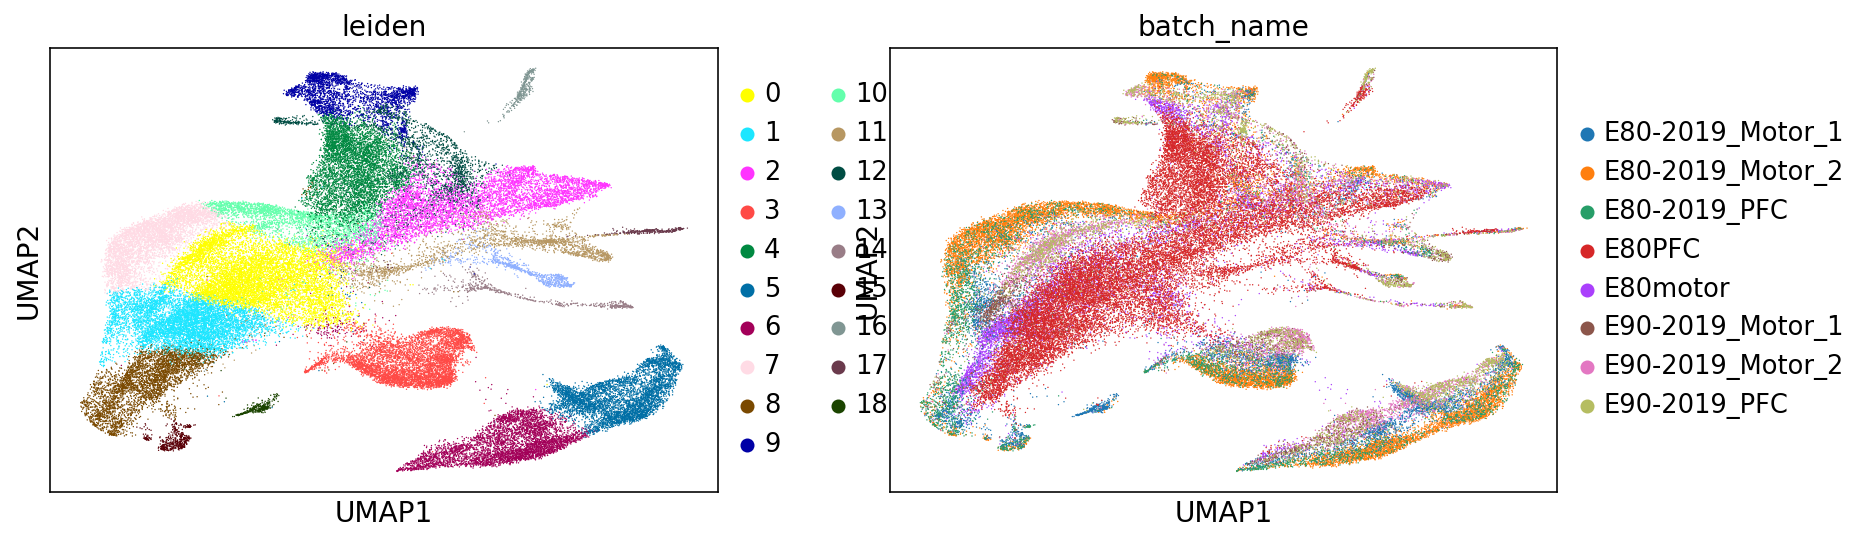

In [42]:
%matplotlib inline

sc.pl.umap(adata,color=['leiden','batch_name'])

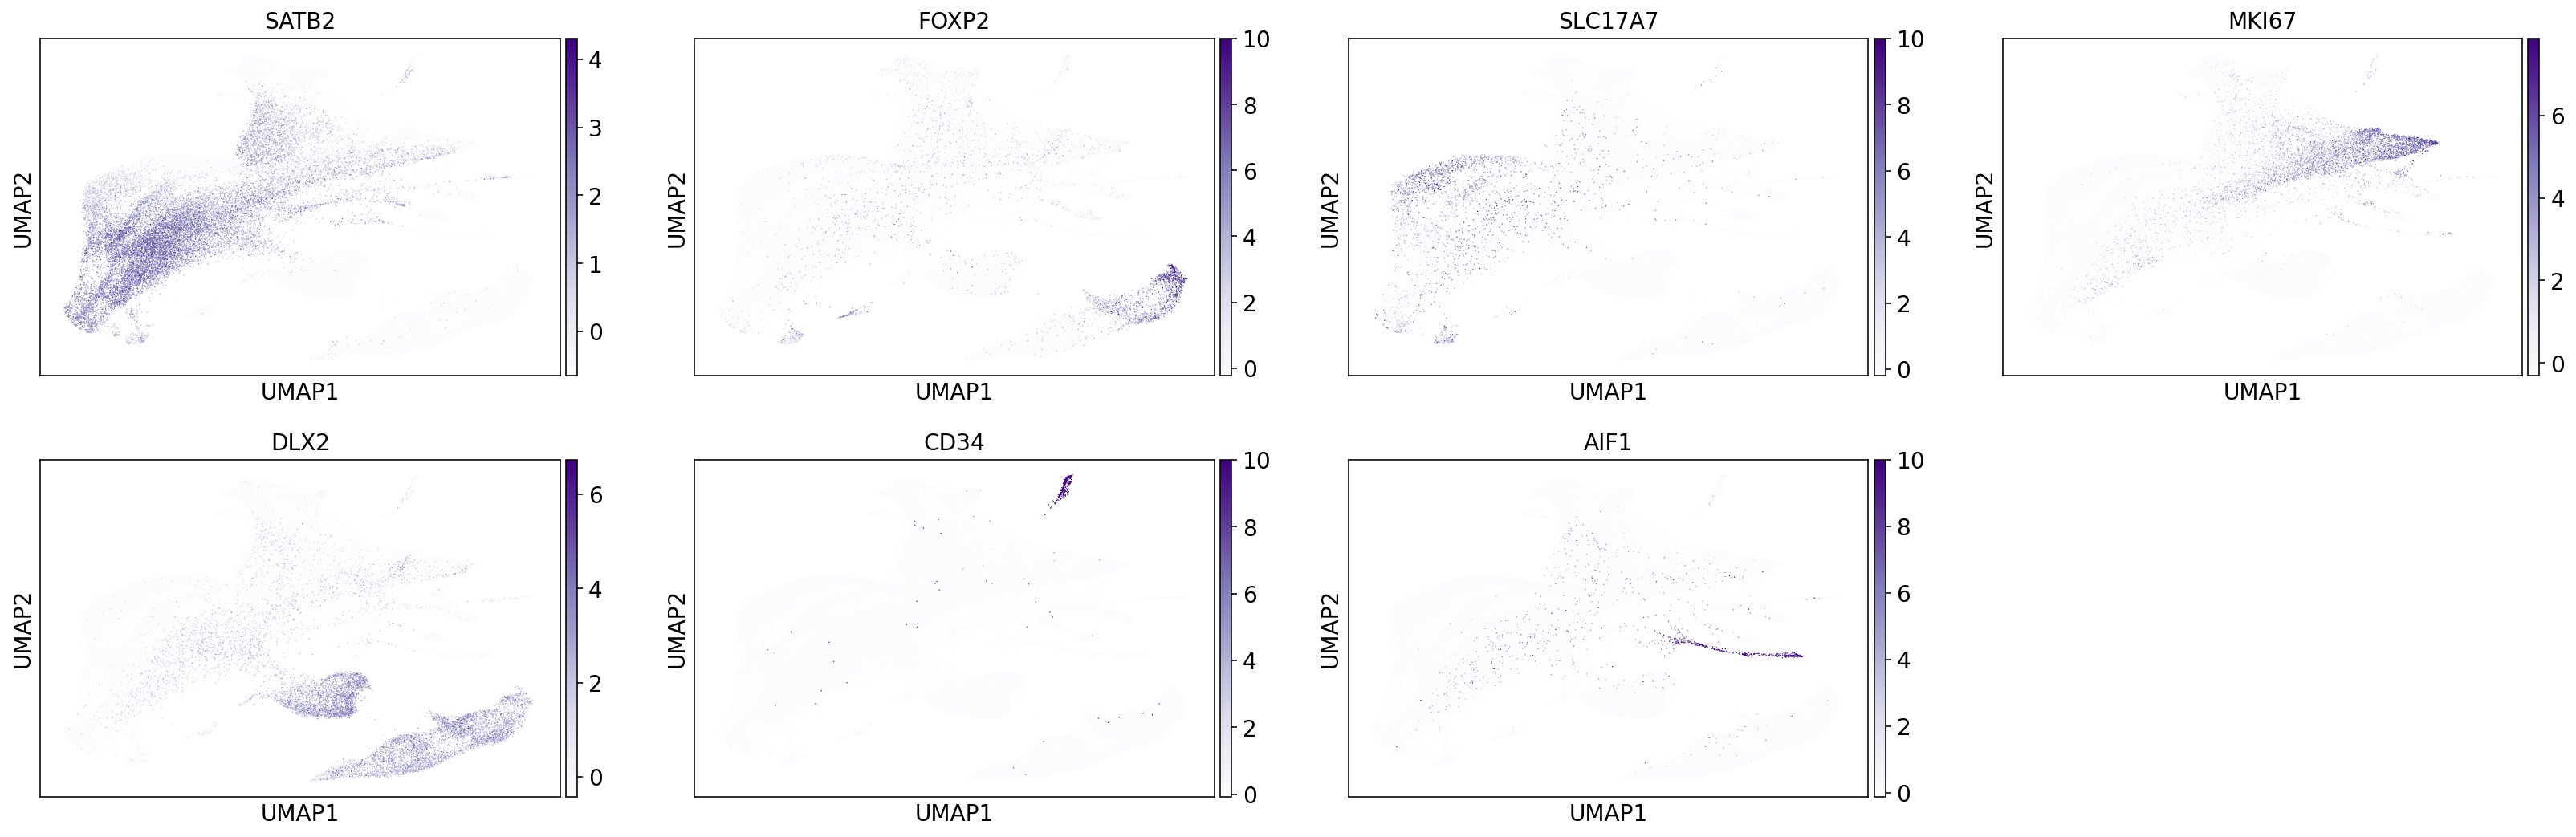

In [40]:
sc.pl.umap(adata,color=['SATB2','FOXP2','SLC17A7','MKI67','AQP4','DLX2','CD34','AIF1'],use_raw=False)

In [53]:
d={}
for b in adata.obs['batch_name'].unique():
    for c in adata.obs.leiden.unique():
        d[str(c)+"___"+b]=adata[(adata.obs.leiden==c)&(adata.obs.batch_name==b),:].raw.X.sum(0).A1
        

In [55]:
pd.DataFrame(d,index=adata.raw.var.index).to_csv('/wynton/home/ye/mschmitz1/forveranome/PseudobulkedCounts.tsv',sep='\t')

In [5]:
d

NameError: name 'd' is not defined

In [18]:
newfile='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMacaqueWbPresuperviseProcessed.h5ad'
newfile='/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityPanHumanPresuperviseProcessed.h5ad'

adata=sc.read(newfile)


In [19]:
adata

AnnData object with n_obs × n_vars = 642452 × 42932
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'percent_ribo', 'percent_mito', 'leiden'
    var: 'feature_type-0', 'id-0', 'name-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-1-100', 'id-1-100', 'name-1-100', 'feature_type-1-101', 'id-1-101', 'name-1-101', 'feature_type-1-102', 'id-1-102', 'name-1-102', 'feature_type-1-103', 'id-1-103', 'name-1-103', 'feature_type-1-104', 'id-1-104', 'name-1-104', 'feature_type-1-105', 'id-1-105', 'name-1-105', 'feature_type-1-106', 'id-1-106', 'name-1-106', 'feature_type-1-107', 'id-1-107', 'name-1-107', 'feature_type-1-108', 'id-1-108', 'name-1-108', 'feature_type-1-109', 'id-1-109', 'name-1-109', 'feature_type-1-11', 'id-1-11', 'name-1-11', 'feature_type-1-110', 'id-1-110', 'name-1-11

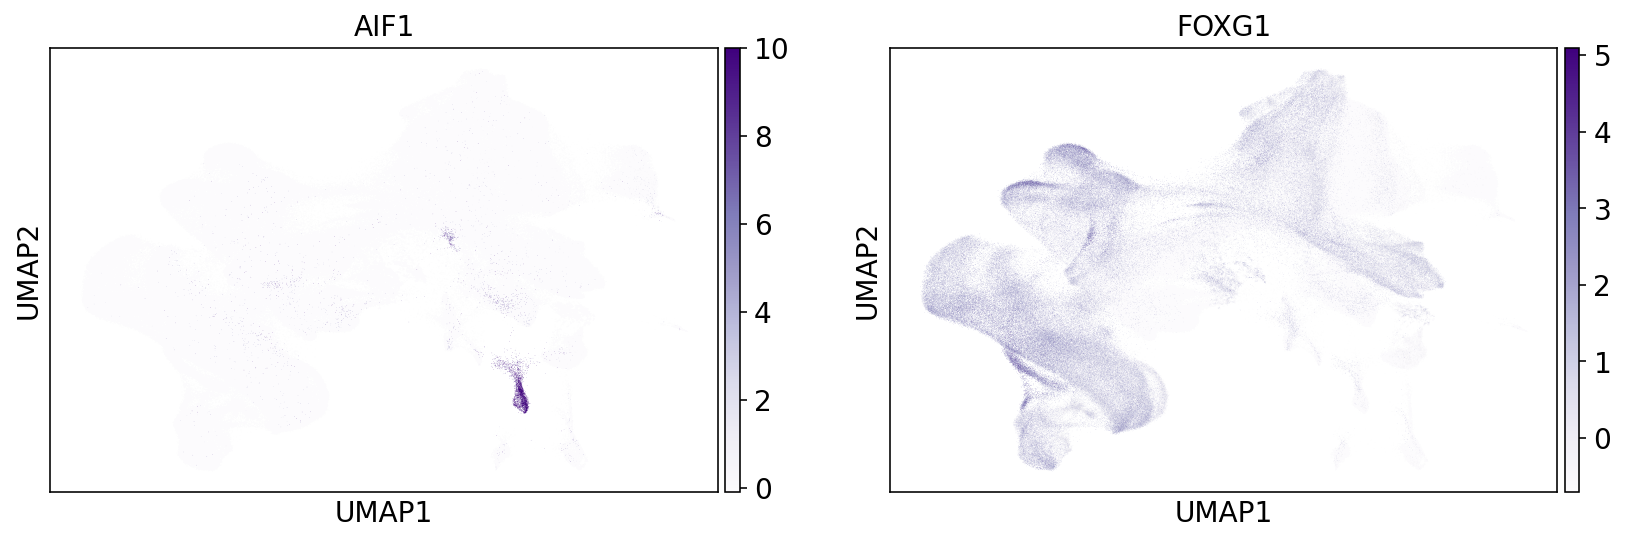

In [23]:
%matplotlib inline
sc.pl.umap(adata,color='leiden', legend_loc='on data')
sc.pl.umap(adata,color=['AIF1','FOXG1'],use_raw=False)

In [26]:
adata[adata.obs['leiden'].isin(['86']),:].write('/wynton/home/ye/mschmitz1/MG_H_4_Chang.h5ad')

In [25]:
adata[adata.obs['leiden'].isin(['86']),:]

View of AnnData object with n_obs × n_vars = 3705 × 42932
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'percent_ribo', 'percent_mito', 'leiden'
    var: 'feature_type-0', 'id-0', 'name-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-1-100', 'id-1-100', 'name-1-100', 'feature_type-1-101', 'id-1-101', 'name-1-101', 'feature_type-1-102', 'id-1-102', 'name-1-102', 'feature_type-1-103', 'id-1-103', 'name-1-103', 'feature_type-1-104', 'id-1-104', 'name-1-104', 'feature_type-1-105', 'id-1-105', 'name-1-105', 'feature_type-1-106', 'id-1-106', 'name-1-106', 'feature_type-1-107', 'id-1-107', 'name-1-107', 'feature_type-1-108', 'id-1-108', 'name-1-108', 'feature_type-1-109', 'id-1-109', 'name-1-109', 'feature_type-1-11', 'id-1-11', 'name-1-11', 'feature_type-1-110', 'id-1-110', 'nam

In [7]:
#adata[adata.obs['percent_ribo']<.4,:]

View of AnnData object with n_obs × n_vars = 634489 × 43420
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'file_name', 'batch_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'demux_type', 'assignment', 'supervised_name', 'percent_ribo', 'percent_mito', 'leiden'
    var: 'feature_type-0-0', 'id-0-0', 'name-0-0', 'feature_type-1-0-0', 'id-1-0-0', 'name-1-0-0', 'feature_type-1-1-0', 'id-1-1-0', 'name-1-1-0', 'feature_type-1-10-0', 'id-1-10-0', 'name-1-10-0', 'feature_type-1-100-0', 'id-1-100-0', 'name-1-100-0', 'feature_type-1-101-0', 'id-1-101-0', 'name-1-101-0', 'feature_type-1-102-0', 'id-1-102-0', 'name-1-102-0', 'feature_type-1-103-0', 'id-1-103-0', 'name-1-103-0', 'feature_type-1-104-0', 'id-1-104-0', 'name-1-104-0', 'feature_type-1-105-0', 'id-1-105-0', 'name-1-105-0', 'feature_type-1-106-0', 'id-1-106-0', 'name-1-106-0', 'feature_type-1-107-0', 'id-1-107-0', 'name-1-107-0', 'feature_type-1-108-0', 'id-1-108-0', 'name-1-108-0', 'fe

In [24]:
%matplotlib inline
sc.pl.umap(adata,color='region')

In [94]:
from collections import OrderedDict
reg_dict=OrderedDict({'cerebel|cbc|[^a-z]ce|vermis|cb':'Cb','vz|cortex|ctx|wt[0-9]+|Neurons_Sample_':'Ctx','ob|GSM3449':'OB','head|all|nan|vesicle|placode':'Head','subpall|sp':'FB','thal|pulv|lgn':'Thal',
 'stria|stiatum|putanum|putamen|caud|accumb|nac|basal|SAMN107673':'Str','gp':'GP','clau':'Ctx-Clau','amy':'Amy',
 'ge':'GE','lge':'LGE','mge':'MGE','somato|som':'Ctx-Somato','cge':'CGE','motor|mop|m1|dfc':'Ctx-MOp',
 'pfc|prefront':'Ctx-PFC','cing':'Ctx-Cing','v1|occ':'Ctx-Occ','central|par':'Ctx-Par','temp':'Ctx-Temp',
 'hippo|ca[0-4]|dent|hc':'Ctx-Hip','forebrain|prosen|diencepha|telenceph':'FB','midbrain|md|[^a-z]mb':'MB','hind':'HB','medull':'Medulla','choroid|cp':'Choroid',
 'sept':'Sept','pre-opt|poa|preoptic':'POA','pons':'Pons','hypo':'Hypo','drg':'DRG','org|cultured':'Cultured','insula':'Ctx-Ins'
})

adata.obs['batch_name']=list(adata.obs['batch_name'].astype(str))
adata.obs['region']=list(adata.obs['region'].astype(str))
if 'msregion' in adata.obs.columns:
    adata.obs['msregion']=list(adata.obs['msregion'].astype(str))

msd=adata.obs['batch_name'].str.contains('multi',case=False)
adata.obs.loc[msd,'msregion']=adata.obs.loc[msd,'region']
adata.obs['msregion']=adata.obs['msregion'].astype(str)
for k in reg_dict.keys():
    print(k)
    adata.obs.loc[adata.obs['msregion'].str.contains(k,case=False),'region']=reg_dict[k]

for k in reg_dict.keys():
    print(k)
    print(reg_dict[k])
    print(adata.obs.loc[adata.obs['batch_name'].str.contains(k,case=False),'batch_name'])
    adata.obs.loc[adata.obs['batch_name'].str.contains(k,case=False),'region']=reg_dict[k]

region_groupings={'ctx': ['Ctx-PFC','Ctx-Cing','Ctx-Clau','Ctx-Ins','Ctx-Hip','Ctx-MOp', 'Ctx-Somato','Ctx','Ctx-Temp','Ctx-Par','Ctx-Occ'],
 'bn':[ 'POA','GP','Sept','Str','Amy'],
 'ob':['OB'],
 'cp':['Choroid'],
 'mb':['MB'],
 'hb':['Pons','Cb','HB','DRG'],
 'ge':['MGE','GE','LGE','CGE'],
 'de':['Hypo', 'FB','Thal'],
 'h':['Head'],
 'xvctx':['Hultured']}

palettes={
'ctx':seaborn.color_palette("YlOrBr",n_colors=len(region_groupings['ctx'])+2).as_hex()[2:],
'bn':seaborn.color_palette("Blues",n_colors=len(region_groupings['bn'])+2).as_hex()[2:],
'ge':seaborn.color_palette("Reds",n_colors=len(region_groupings['ge'])+2).as_hex()[2:],
'hb':seaborn.color_palette("Greens",n_colors=len(region_groupings['hb'])+2).as_hex()[2:],
'de':seaborn.color_palette("Purples",n_colors=len(region_groupings['de'])+2).as_hex()[2:],
'ob':['magenta'],
'mb':['cyan'],#turquoise
'cp':['slategray'],
'xvctx':['lightgray'],
'h':['tan']
}

adata.obs['region']=adata.obs['region'].astype('category')
regions=[]
region_colors=[]
for k in palettes.keys():
    regions+=region_groupings[k]
    region_colors+=palettes[k]

region_colors=[col for reg,col in zip(regions,region_colors) if reg in adata.obs['region'].cat.categories]
cats=[x for x in regions if x in adata.obs['region'].cat.categories]
missings=list(set(adata.obs['region'].cat.categories)-set(cats))

print(cats+missings)
paldict=dict(zip(cats+missings,region_colors+['grey' for i in range(len(missings))]))

region_colors=[paldict[x] for x in adata.obs['region'].cat.categories]
#adata.obs['region'].cat.categories=cats+missings
adata.uns['region_colors']=region_colors


cerebel|cbc|[^a-z]ce|vermis|cb
vz|cortex|ctx|wt[0-9]+|Neurons_Sample_
ob|GSM3449
head|all|nan|vesicle|placode
subpall|sp
thal|pulv|lgn
stria|stiatum|putanum|putamen|caud|accumb|nac|basal|SAMN107673
gp
clau
amy
ge
lge
mge
somato|som
cge
motor|mop|m1|dfc
pfc|prefront
cing
v1|occ
central|par
temp
hippo|ca[0-4]|dent|hc
forebrain|prosen|diencepha|telenceph
midbrain|md|[^a-z]mb
hind
medull
choroid|cp
sept
pre-opt|poa|preoptic
pons
hypo
drg
org|cultured
insula
cerebel|cbc|[^a-z]ce|vermis|cb
Cb
CTTACCGTCTGGCCGA_E80-2019_Cerebellum                                      E80-2019_Cerebellum
CATTGTTGTGTTTACG_E80-2019_Cerebellum                                      E80-2019_Cerebellum
ACCTACCTCACGGGCT_E80-2019_Cerebellum                                      E80-2019_Cerebellum
CTCATTATCATGAGGG_E80-2019_Cerebellum                                      E80-2019_Cerebellum
CTACGGGTCCCGTTCA_E80-2019_Cerebellum                                      E80-2019_Cerebellum
                                      

In [95]:
[paldict[x] for x in adata.obs['region'].cat.categories]

['#08509b',
 '#aa1016',
 '#56b567',
 'slategray',
 '#feda7e',
 '#fec859',
 '#fe9829',
 '#feb23f',
 '#f4811d',
 '#832d05',
 '#fee99e',
 '#a03704',
 '#e76b11',
 '#bc4503',
 '#05712f',
 '#2c944c',
 'tan',
 '#9e9ac8',
 '#d52221',
 'cyan',
 '#fc8161',
 '#9dcae1',
 '#8ed08b',
 '#4191c6',
 '#2070b4',
 '#5b3495']

In [89]:
adata.obs.groupby('batch_name')['region'].value_counts().unstack().idxmax(1).to_dict()

{'E100PFC': 'Ctx-PFC',
 'E100V1': 'Ctx-Occ',
 'E100caudateANDextBGANDintBGANDputanum': 'Str',
 'E100cingulate': 'Ctx-Cing',
 'E100hippo': 'Ctx-Hip',
 'E100hypothalamusANDPoA': 'Hypo',
 'E100insula': 'Ctx-Ins',
 'E100motor': 'Ctx-MOp',
 'E100parietal': 'Ctx-Par',
 'E100pulvinarANDdorsalThalamusANDventralThalamus': 'Thal',
 'E100septumANDnucleusAccumbens': 'Sept',
 'E100somato': 'Ctx-Somato',
 'E100temporal': 'Ctx-Temp',
 'E40_CGE-LGE': 'CGE',
 'E40_Choroid': 'Choroid',
 'E40_DRG': 'DRG',
 'E40_Hindbrain': 'HB',
 'E40_Hypo': 'Hypo',
 'E40_MGE': 'MGE',
 'E40_Midbrain': 'MB',
 'E40_PFC': 'Ctx-PFC',
 'E40_Pre-optic': 'POA',
 'E40_V1': 'Ctx-Occ',
 'E40_motor': 'Ctx-MOp',
 'E40_somato': 'Ctx-Somato',
 'E40_thalamus': 'Thal',
 'E40hippo': 'Ctx-Hip',
 'E50_CGE-LGE': 'CGE',
 'E50_MGE': 'MGE',
 'E50_PFC': 'Ctx-PFC',
 'E50_V1': 'Ctx-Occ',
 'E50_cerebellum': 'Cb',
 'E50_choroid': 'Choroid',
 'E50_hindbrain': 'HB',
 'E50_hypo': 'Hypo',
 'E50_motor': 'Ctx-MOp',
 'E50_parietal': 'Ctx-Par',
 'E50_septu

In [78]:
adata.obs.region.cat.categories

Index(['Amy', 'CGE', 'Cb', 'Choroid', 'Ctx-Cing', 'Ctx-Clau', 'Ctx-Hip',
       'Ctx-Ins', 'Ctx-MOp', 'Ctx-Occ', 'Ctx-PFC', 'Ctx-Par', 'Ctx-Somato',
       'Ctx-Temp', 'DRG', 'HB', 'LGE', 'MB', 'MGE', 'POA', 'Pons', 'Sept',
       'Str', 'Thal', 'hypo', 'nan'],
      dtype='object')

In [5]:
supercell=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/MacWB_basetypes.csv')
ind=adata.obs.index[adata.obs['full_cellname'].isin(supercell['full_cellname'])]
supercell.index=supercell['full_cellname']
supercell=supercell.loc[ind,:]
adata.obs.loc[ind,'base_types']=supercell['base_types']
adata.obs['supervised_name']=adata.obs['supervised_name'].astype(str)


FileNotFoundError: [Errno 2] No such file or directory: '/wynton/group/ye/mtschmitz/macaquedevbrain/MacWB_basetypes.csv'

In [6]:
supercell

NameError: name 'supercell' is not defined

In [ ]:
"""
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMacaqueWbPresupervisectx|ge|bn_subset.h5ad
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityMouseWbPresupervisionctx|ge|bn_subset.h5ad
/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityPanHumanPresupervisectx|ge|bn_subset.h5ad

"""

adata=sc.read('/wynton/group/ye/mtschmitz/macaquedevbrain/CAT202002_h5ad/KDCbVelocityPanHumanPresuperviseProcessed.h5ad')

In [ ]:
%matplotlib inline
sc.pl.umap(adata,color=["MKI67","ASPM","PPP1R17",'EOMES',"SLC1A3",'AQP4','RBFOX3'],use_raw=False)

In [ ]:
sc.tl.leiden(adata,resolution=0.8)

In [12]:
del adata.uns['leiden_colors']

KeyError: 'leiden_colors'

In [13]:
sc.pl.umap(adata,color=['leiden'],use_raw=False,legend_loc='on data')

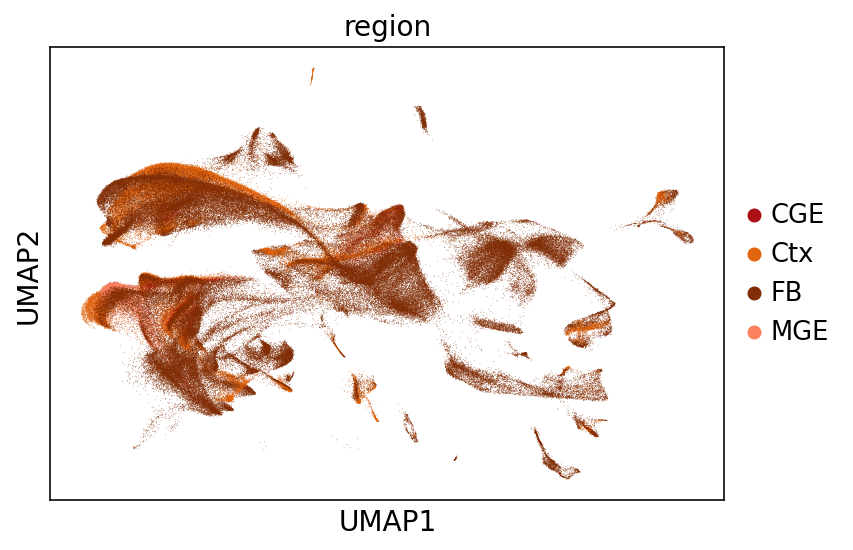

In [14]:
sc.pl.umap(adata,color=['region'],use_raw=False)

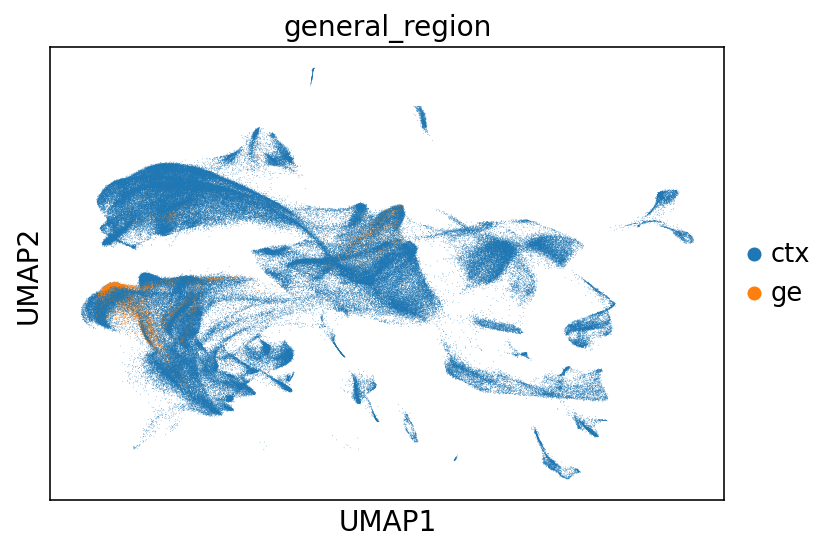

In [15]:
sc.pl.umap(adata,color=['general_region'],use_raw=False)

In [ ]:
adata[adata.obs['leiden'].isin(['2','9','4','12']),:].write('/wynton/scratch/mtschmitz/supervising/NEU_M.h5ad')

In [11]:
adata

AnnData object with n_obs × n_vars = 271183 × 33340
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'leiden', 'supervised_name', 'percent_ribo', 'percent_mito'
    var: 'feature_type-0', 'id-0', 'name-0', 'feature_type-1-0', 'id-1-0', 'name-1-0', 'feature_type-1-1', 'id-1-1', 'name-1-1', 'feature_type-1-10', 'id-1-10', 'name-1-10', 'feature_type-1-100', 'id-1-100', 'name-1-100', 'feature_type-1-101', 'id-1-101', 'name-1-101', 'feature_type-1-102', 'id-1-102', 'name-1-102', 'feature_type-1-103', 'id-1-103', 'name-1-103', 'feature_type-1-104', 'id-1-104', 'name-1-104', 'feature_type-1-105', 'id-1-105', 'name-1-105', 'feature_type-1-106', 'id-1-106', 'name-1-106', 'feature_type-1-107', 'id-1-107', 'name-1-107', 'feature_type-1-108', 'id-1-108', 'name-1-108', 'feature_type-1-109', 'id-1-109', 'name-1-109', 'feature_type-1-11', 'id-1-11', 'nam